# **Generative Adversarial Networks (GANs)**

In this assignment, you will implement a Generative Adversarial Network which generates images of human faces. Your model will use a basic generator + discriminator setup, where training alternates between updating the generator and the discriminator. The generator will be an up-convolutional network which maps a random latent code to an image, and the discriminator will be a down-convolutional network which maps an image to a real/fake probability. The model you will implement will be based on the ‘DCGAN’ architecture described in this paper. DCGANs are a standard baseline for generative image-based modeling. They replace max pooling with convolutional stride, eliminate fully connected layers, and use transposed convolution for upsampling.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data ($\sim$ just means 'drawn from' &mdash; so $x$ consists of our samples, each of which are 'drawn from' $p_\text{data}$, our entire set of input data.), $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. [Goodfellow et al.](https://arxiv.org/abs/1406.2661) analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will alternate between taking gradient *descent* steps on the objective for $G$ (this corresponds to gradient ascent on the loss function), and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to **minimize** the probability of the **discriminator** making the correct choice. 
2. update the **discriminator** ($D$) to **maximize** the probability of the **discriminator** making the correct choice.

As a way to simplify the math, we **update the generator: maximize the probability of the discriminator making the incorrect choice**. This allows us to use two maximize functions as opposed to one minimize and one maximize. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://paperswithcode.com/task/image-generation). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).

# **Setup**
Here we define some useful visualization functions and download the data for testing your loss and activation functions. 

**If you are using this in colab, WHILE YOU ARE CODING, on the toolbar, click Runtime -> Change Runtime Type and make sure hardware accelerator is None** Because colab only allows a small amount of GPU time per day, you will want to debug your code first and then when you are confident it works, enable the GPU and train the full scale network for at least 2 epochs to see some quality images.

NOTE: a full scale network takes about 1.5 hours to train for >5 epochs on a standard google colab backed GPU.

In [1]:
!pip install tensorflow_gan

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

tf.keras.backend.set_floatx('float32')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

def display_images(images, save=None):
  fig = plt.figure(figsize=(8, 8))

  for i in range(min(images.shape[0], 16)):
      plt.subplot(4, 4, i+1)
      plt.imshow((images[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8))
      plt.axis('off')

  if save is not None:
      plt.savefig(save)
  plt.show()

## --------------------------------------------------------------------------------------
import tensorflow_hub as hub
import tensorflow_gan as tfgan

# For evaluating the quality of generated images
# Frechet Inception Distance measures how similar the generated images are to the real ones
# https://nealjean.com/ml/frechet-inception-distance/
# Lower is better
module = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/classification/4", output_shape=[1001])])
def fid_function(real_image_batch, generated_image_batch):
    """
    Given a batch of real images and a batch of generated images, this function pulls down a pre-trained inception 
    v3 network and then uses it to extract the activations for both the real and generated images. The distance of 
    these activations is then computed. The distance is a measure of how "realistic" the generated images are.

    :param real_image_batch: a batch of real images from the dataset, shape=[batch_size, height, width, channels]
    :param generated_image_batch: a batch of images generated by the generator network, shape=[batch_size, height, width, channels]

    :return: the inception distance between the real and generated images, scalar
    """
    INCEPTION_IMAGE_SIZE = (299, 299)
    real_resized = tf.image.resize(real_image_batch, INCEPTION_IMAGE_SIZE)
    fake_resized = tf.image.resize(generated_image_batch, INCEPTION_IMAGE_SIZE)
    module.build([None, 299, 299, 3])
    real_features = module(real_resized)
    fake_features = module(fake_resized)
    return tfgan.eval.frechet_classifier_distance_from_activations(real_features, fake_features)

You should consider upgrading via the 'c:\users\ryan\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


##Load dataset

In [2]:
![ -f 'img_align_celeba.zip' ] || wget --content-disposition https://www.dropbox.com/s/o2cfewccmxqrg2x/img_align_celeba.zip?dl=0

![ -d '/content/dataset' ] || unzip -q -d /content/dataset img_align_celeba.zip

'[' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'[' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Sets up tensorflow graph to load images
# (This is the version using new-style tf.data API)
def load_image_batch(dir_name, batch_size=128, shuffle_buffer_size=250000, n_threads=2):
    """
    Given a directory and a batch size, the following method returns a dataset iterator that can be queried for 
    a batch of images

    :param dir_name: a batch of images
    :param batch_size: the batch size of images that will be trained on each time
    :param shuffle_buffer_size: representing the number of elements from this dataset from which the new dataset will 
    sample
    :param n_thread: the number of threads that will be used to fetch the data

    :return: an iterator into the dataset
    """
    # Function used to load and pre-process image files
    # (Have to define this ahead of time b/c Python does allow multi-line
    #    lambdas, *grumble*)
    def load_and_process_image(file_path):
        """
        Given a file path, this function opens and decodes the image stored in the file.

        :param file_path: a batch of images

        :return: an rgb image
        """
        # Load image
        image = tf.io.decode_jpeg(tf.io.read_file(file_path), channels=3)
        image = tf.image.resize(image, [64,64])
        
        # Convert image to normalized float (0, 1)
        image = tf.image.convert_image_dtype(image, tf.float32) / 256.0
        # Rescale data to range (-1, 1)
        image = (image - 0.5) * 2
        return image

    # List file names/file paths
    dir_path = dir_name + '/*.jpg'
    dataset = tf.data.Dataset.list_files(dir_path)

    # Shuffle order
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)

    # Load and process images (in parallel)
    dataset = dataset.map(map_func=load_and_process_image, num_parallel_calls=n_threads)

    # Create batch, dropping the final one which has less than batch_size elements and finally set to reshuffle
    # the dataset at the end of each iteration
    dataset = dataset.batch(batch_size, drop_remainder=True)

    # Prefetch the next batch while the GPU is training
    dataset = dataset.prefetch(1)

    # Return an iterator over this dataset
    return dataset

# **Building the Discriminator and the Generator**

You should complete code here for your discriminator and generator models. You should build them using keras' Sequential model and layers and use the constant for GEN_DEPTH and KERNEL_DEPTH to define the depth (number of channels) of each layer. See writeup for more instructions.

In [4]:
#GEN_DEPTH = 1024 #uncomment for the full scale model
GEN_DEPTH = 128
KERNEL_DEPTH = GEN_DEPTH // 2

def make_generator_model():
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    model.add(layers.Dense(4*4*GEN_DEPTH, use_bias=False, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, GEN_DEPTH)))
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(filters=(GEN_DEPTH / 2), kernel_size=5, strides=(2, 2), padding="same", activation="relu", kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(filters=(GEN_DEPTH / 4), kernel_size=5, strides=(2, 2), padding="same", activation="relu", kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(filters=(GEN_DEPTH / 8), kernel_size=5, strides=(2, 2), padding="same", activation="relu", kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=5, strides=(2, 2), padding="same", activation="tanh", kernel_initializer=initializer))
    
    #TODO: fill in the generator model layers
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    #TODO: fill in the discriminator model layers
    model.add(layers.Conv2D(input_shape= (64, 64, 3),filters=(GEN_DEPTH / 8), kernel_size=5, strides=(2, 2), padding="same", kernel_initializer=initializer))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(filters=(GEN_DEPTH / 4), kernel_size=5, strides=(2, 2), padding="same", kernel_initializer=initializer))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=(GEN_DEPTH / 2), kernel_size=5, strides=(2, 2), padding="same", kernel_initializer=initializer))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=(GEN_DEPTH), kernel_size=5, strides=(2, 2), padding="same", kernel_initializer=initializer))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [5]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Training


In [6]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return generated_images, gen_loss, disc_loss

# Train the model for one epoch.
def train_epoch(generator, discriminator, dataset_iterator, manager, batch_size, validate_image_seeds=None):
    """
    Train the model for one epoch. Save a checkpoint every 500 or so batches.

    :param generator: generator model
    :param discriminator: discriminator model
    :param dataset_ierator: iterator over dataset, see preprocess.py for more information
    :param manager: the manager that handles saving checkpoints by calling save()

    :return: The average FID score over the epoch
    """
    fids = []
    # Loop over our data until we run out
    for iteration, batch in enumerate(dataset_iterator):
        generated_images, gen_loss, disc_loss = train_step(batch, batch_size)

        # Calculate inception distance and track the fid in order
        # to return the average
        if iteration % 100 == 0:
            print("iteration ",iteration, " gen loss", gen_loss.numpy(), " disc loss", disc_loss.numpy())
            fid_ = fid_function(batch, generated_images)
            fids.append(fid_)
            print('**** INCEPTION DISTANCE: %g ****' % fid_)
            if validate_image_seeds is not None:
              display_images(generator(validate_image_seeds, training=False))
            else:
              display_images(generated_images)
        if iteration % 500 == 0:
            # Save
            manager.save()
    return np.mean(np.array(fids))

#main

In [7]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
batch_size = 128

img_dir = 'C:/Users/Ryan/Desktop/MyProjects/COSC440Assignment3/content/dataset/img_align_celeba'
out_dir = './output'
checkpoint_dir = './checkpoints'

mode = 'train'
# mode = 'test'
restore_checkpoint = (mode == 'test') or False


In [8]:
# !rm -rf checkpoints

Generator Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              204800    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 64)          204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 

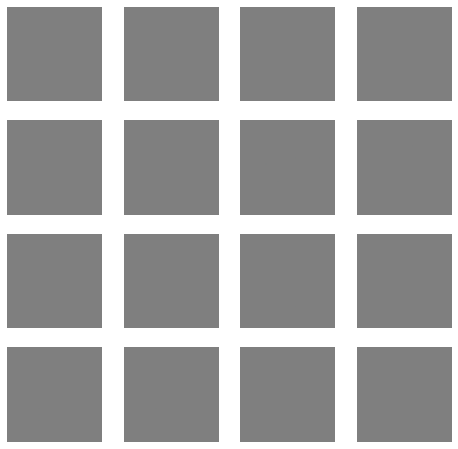

iteration  100  gen loss 6.8100815  disc loss 0.024439145
**** INCEPTION DISTANCE: 1954.37 ****


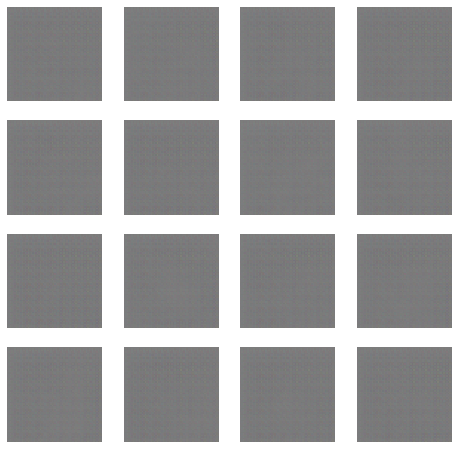

iteration  200  gen loss 5.4428067  disc loss 0.038346443
**** INCEPTION DISTANCE: 607.392 ****


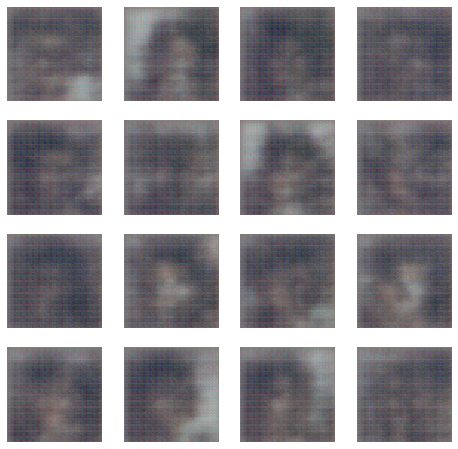

iteration  300  gen loss 3.4145603  disc loss 0.35506362
**** INCEPTION DISTANCE: 450.629 ****


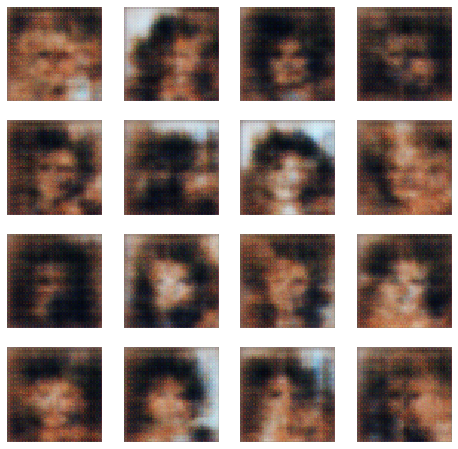

iteration  400  gen loss 3.477669  disc loss 0.35545963
**** INCEPTION DISTANCE: 360.088 ****


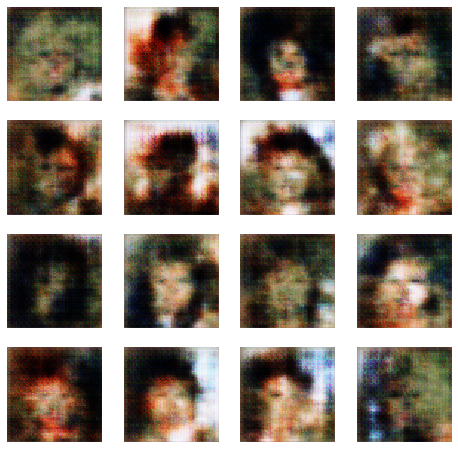

iteration  500  gen loss 2.7608526  disc loss 0.5635791
**** INCEPTION DISTANCE: 378.151 ****


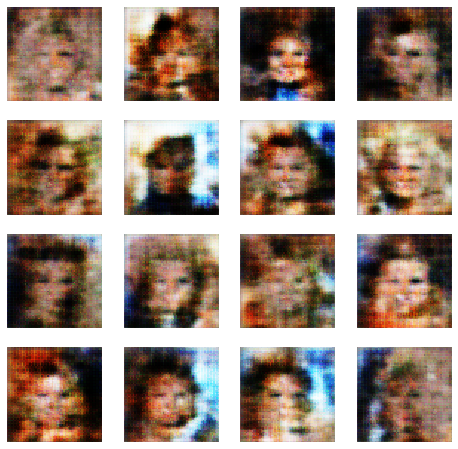

iteration  600  gen loss 0.6939413  disc loss 1.4026481
**** INCEPTION DISTANCE: 355.953 ****


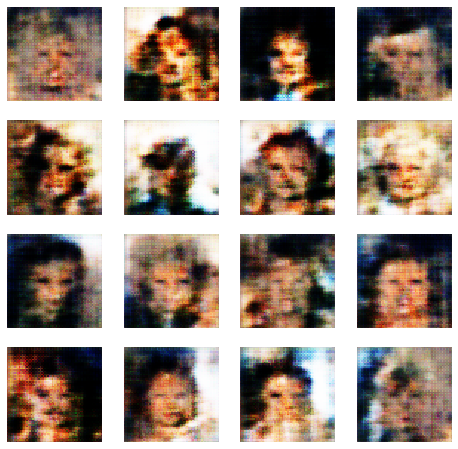

iteration  700  gen loss 2.3540854  disc loss 0.39742088
**** INCEPTION DISTANCE: 453.985 ****


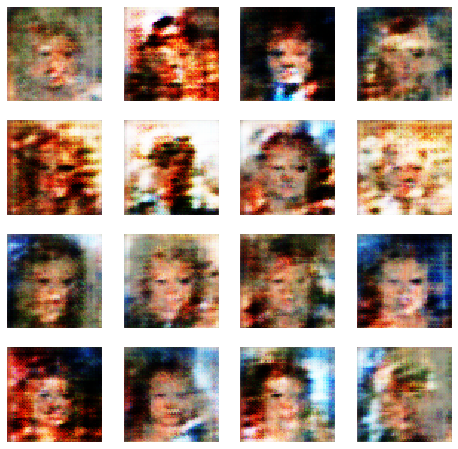

iteration  800  gen loss 1.9366906  disc loss 0.55346656
**** INCEPTION DISTANCE: 416.936 ****


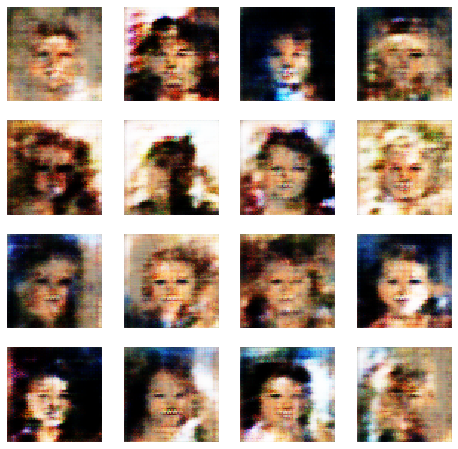

iteration  900  gen loss 2.860765  disc loss 0.37009925
**** INCEPTION DISTANCE: 354.652 ****


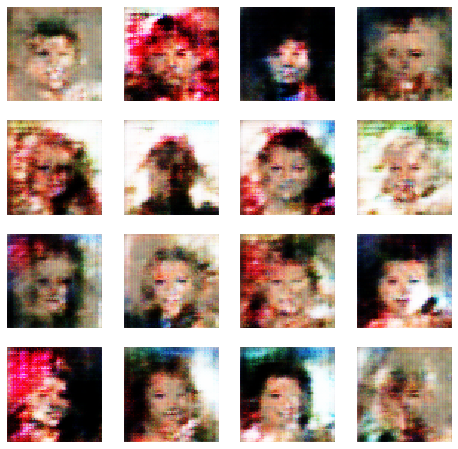

iteration  1000  gen loss 2.6712403  disc loss 0.38031182
**** INCEPTION DISTANCE: 345.442 ****


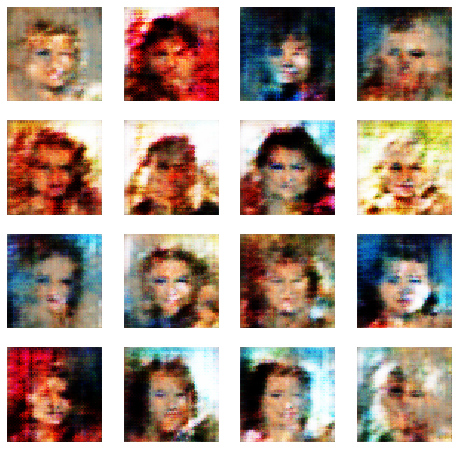

iteration  1100  gen loss 3.7014713  disc loss 0.2751601
**** INCEPTION DISTANCE: 324.487 ****


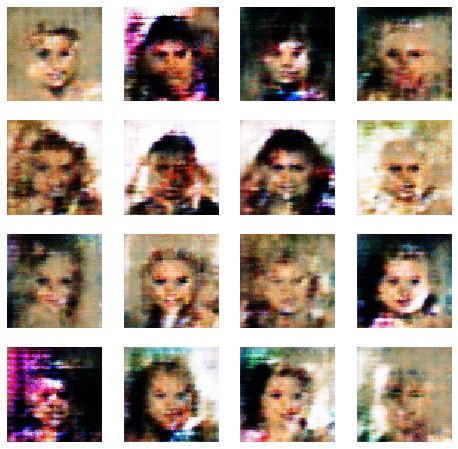

iteration  1200  gen loss 3.280143  disc loss 0.37499315
**** INCEPTION DISTANCE: 321.945 ****


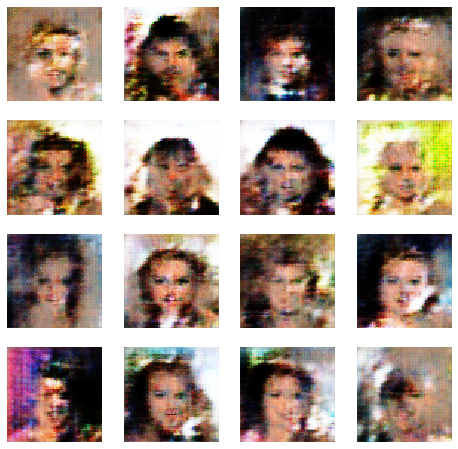

iteration  1300  gen loss 1.6334713  disc loss 0.4994915
**** INCEPTION DISTANCE: 300.502 ****


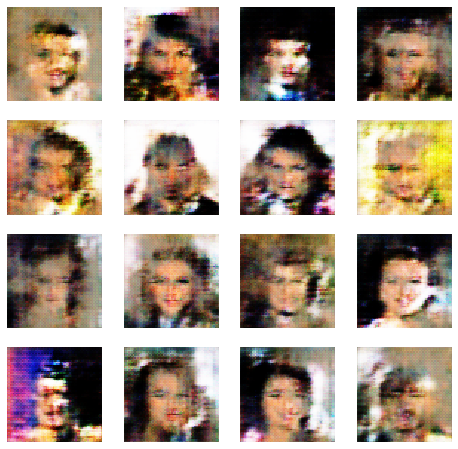

iteration  1400  gen loss 1.5867597  disc loss 0.61574703
**** INCEPTION DISTANCE: 332.866 ****


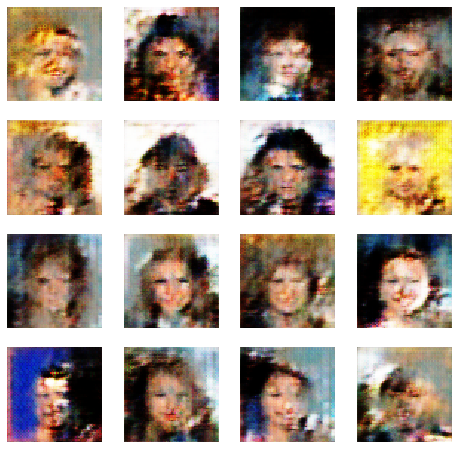

iteration  1500  gen loss 2.9860444  disc loss 0.41774768
**** INCEPTION DISTANCE: 284.811 ****


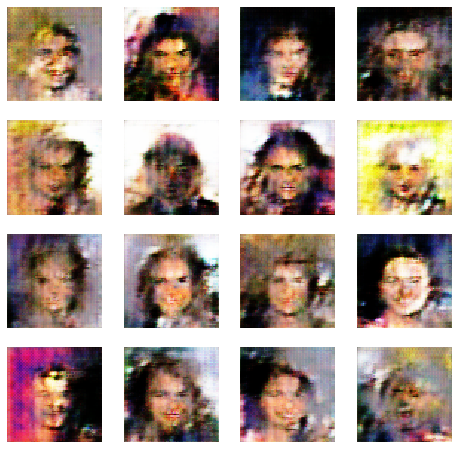

Average FID for Epoch: 570.352
**** SAVING CHECKPOINT AT END OF EPOCH ****


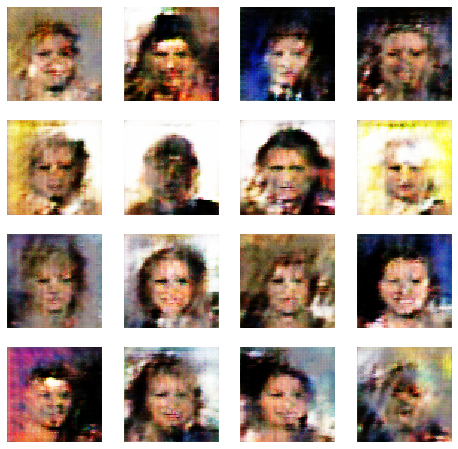

========================== EPOCH 1  ==========================
iteration  0  gen loss 3.4871979  disc loss 0.5299088
**** INCEPTION DISTANCE: 255.997 ****


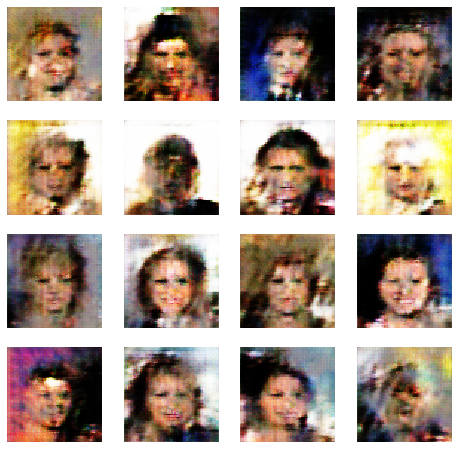

iteration  100  gen loss 1.9081635  disc loss 0.6322419
**** INCEPTION DISTANCE: 267.975 ****


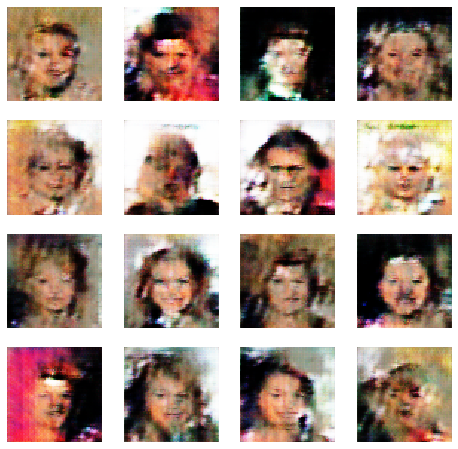

iteration  200  gen loss 1.3249427  disc loss 0.8446114
**** INCEPTION DISTANCE: 242.995 ****


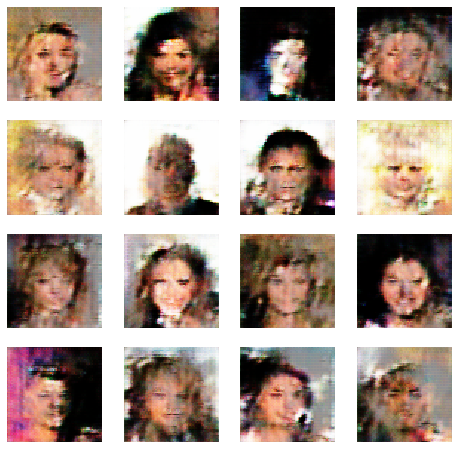

iteration  300  gen loss 1.6608479  disc loss 0.51154757
**** INCEPTION DISTANCE: 259.99 ****


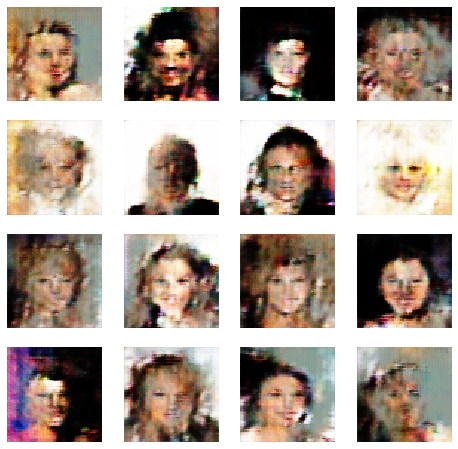

iteration  400  gen loss 3.1669052  disc loss 0.690555
**** INCEPTION DISTANCE: 341.564 ****


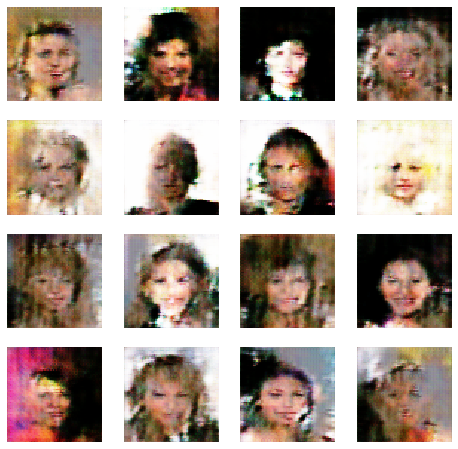

iteration  500  gen loss 1.3915002  disc loss 0.63631934
**** INCEPTION DISTANCE: 263.626 ****


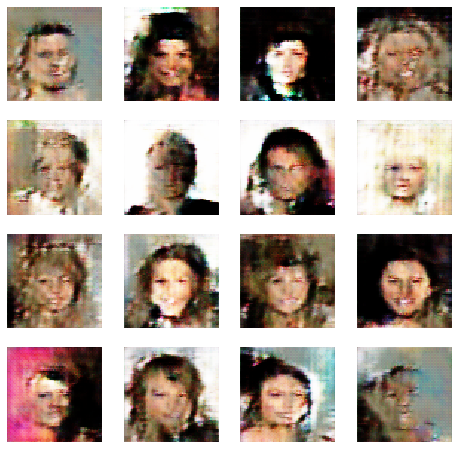

iteration  600  gen loss 0.87481403  disc loss 0.9094951
**** INCEPTION DISTANCE: 271.617 ****


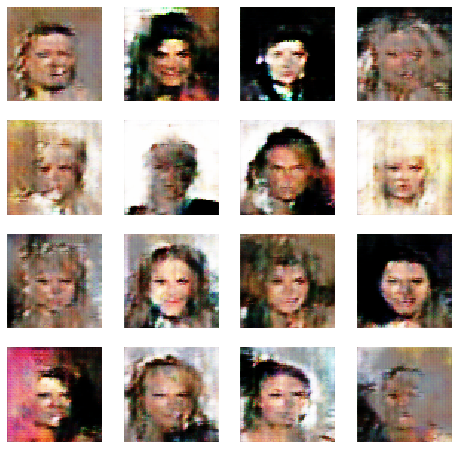

iteration  700  gen loss 2.2938955  disc loss 0.42818257
**** INCEPTION DISTANCE: 238.939 ****


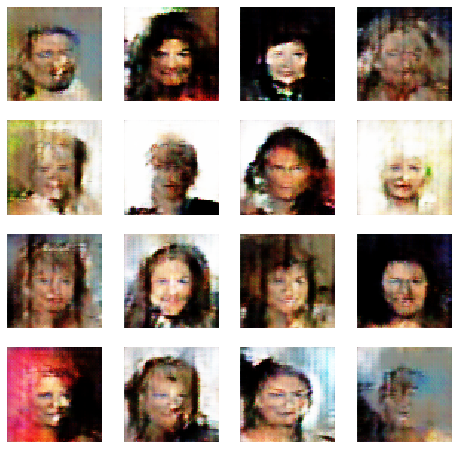

iteration  800  gen loss 1.7597384  disc loss 0.5071912
**** INCEPTION DISTANCE: 242.353 ****


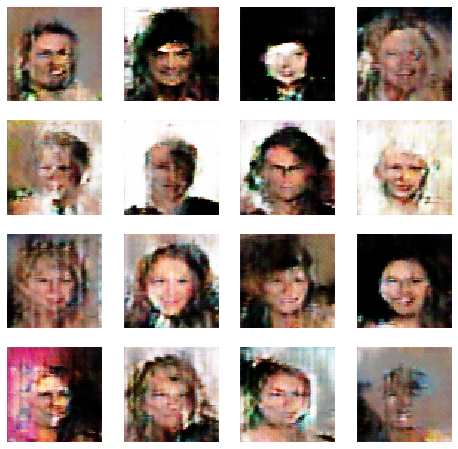

iteration  900  gen loss 2.5719974  disc loss 0.26647568
**** INCEPTION DISTANCE: 208.475 ****


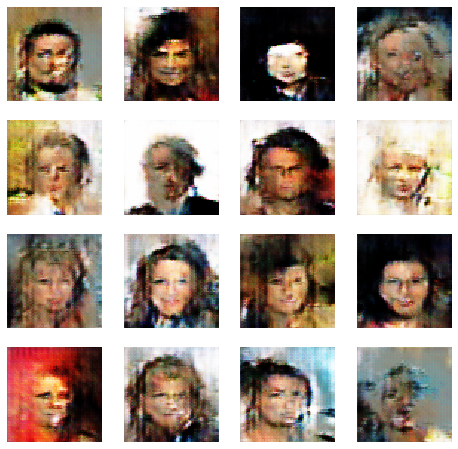

iteration  1000  gen loss 4.1667356  disc loss 0.6779444
**** INCEPTION DISTANCE: 231.421 ****


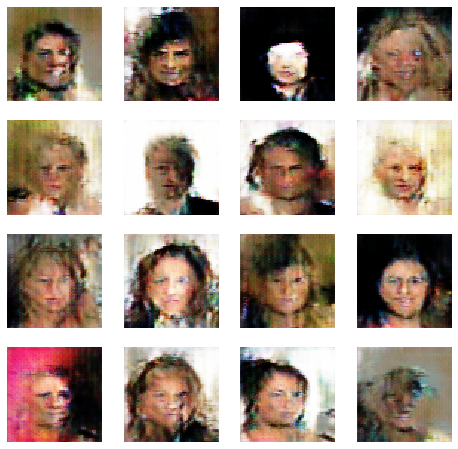

iteration  1100  gen loss 4.010772  disc loss 0.51640636
**** INCEPTION DISTANCE: 207.835 ****


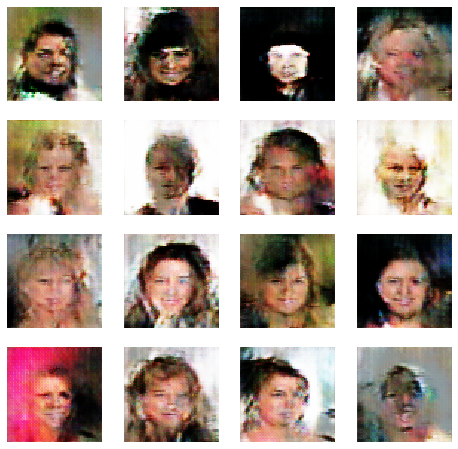

iteration  1200  gen loss 2.398635  disc loss 0.39654586
**** INCEPTION DISTANCE: 244.348 ****


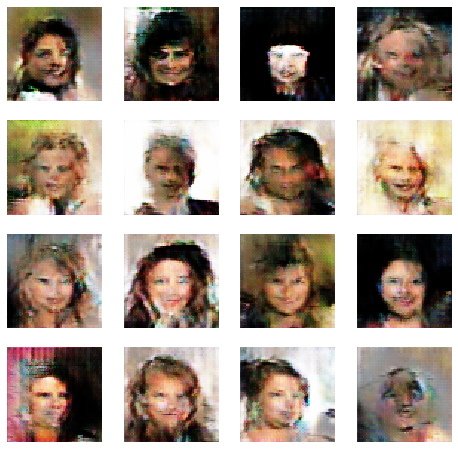

iteration  1300  gen loss 2.623839  disc loss 0.29606032
**** INCEPTION DISTANCE: 217.133 ****


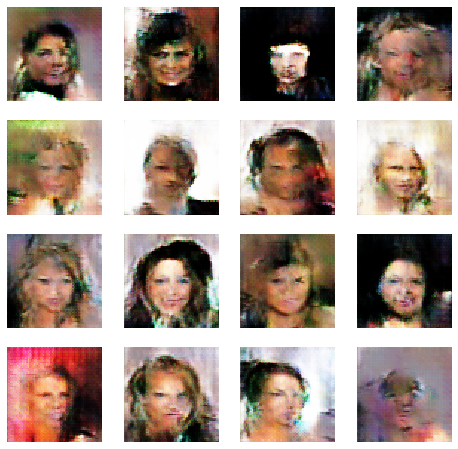

iteration  1400  gen loss 0.14906608  disc loss 2.8195496
**** INCEPTION DISTANCE: 226.37 ****


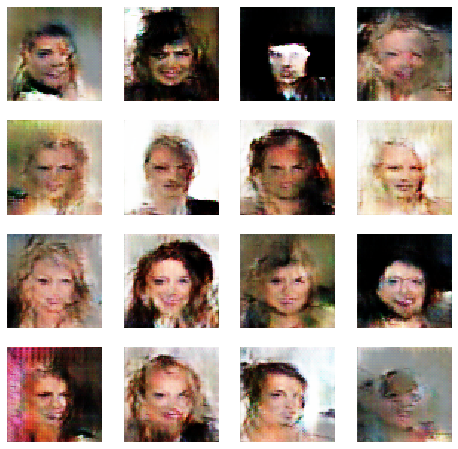

iteration  1500  gen loss 3.0291307  disc loss 0.63479733
**** INCEPTION DISTANCE: 271.76 ****


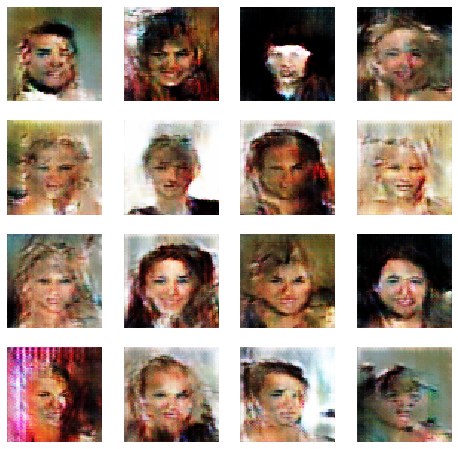

Average FID for Epoch: 249.5249
**** SAVING CHECKPOINT AT END OF EPOCH ****


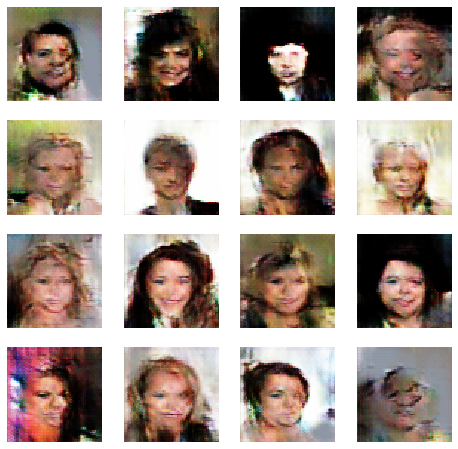

========================== EPOCH 2  ==========================
iteration  0  gen loss 2.4881659  disc loss 0.31530094
**** INCEPTION DISTANCE: 215.607 ****


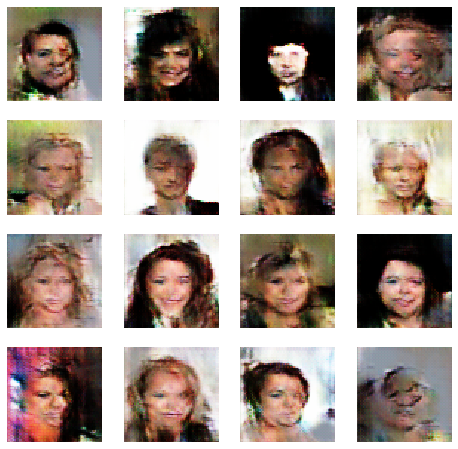

iteration  100  gen loss 2.4880223  disc loss 0.56623137
**** INCEPTION DISTANCE: 217.787 ****


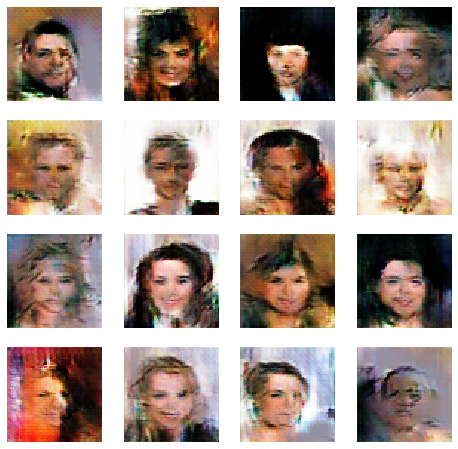

iteration  200  gen loss 2.923189  disc loss 0.40265304
**** INCEPTION DISTANCE: 233.727 ****


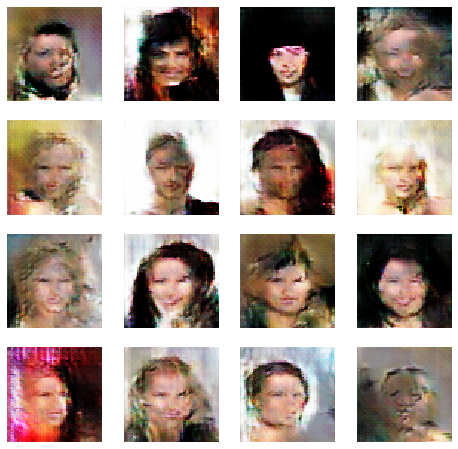

iteration  300  gen loss 2.5471146  disc loss 0.34132957


KeyboardInterrupt: 

In [9]:
# Load a batch of images (to feed to the discriminator)
dataset_iterator = load_image_batch(img_dir, batch_size=batch_size, n_threads=2)

# Initialize generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

print("Generator Summary")
generator.summary()
print("Discriminator Summary")
discriminator.summary()

#The discriminator and the generator optimizers are different since you will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

# For saving/loading models
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# Ensure the output directory exists
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

if restore_checkpoint:
    # restores the latest checkpoint using from the manager
    checkpoint.restore(manager.latest_checkpoint) 

validate_image_seeds = tf.random.normal([batch_size, noise_dim])

if mode == 'train':
    for epoch in range(0, EPOCHS):
        print('========================== EPOCH %d  ==========================' % epoch)
        avg_fid = train_epoch(generator, discriminator, dataset_iterator, manager, 
                              batch_size=batch_size, validate_image_seeds=validate_image_seeds)
        print("Average FID for Epoch: " + str(avg_fid))
        # Save at the end of the epoch, too
        print("**** SAVING CHECKPOINT AT END OF EPOCH ****")
        manager.save()
        display_images(generator(validate_image_seeds, training=False), 
                       save='image_at_epoch_{:04d}.png'.format(epoch))

elif mode == 'test':
    display_images(generator(validate_image_seeds, training=False), save='image_test.png')




Assignment used with permission and significantly modified for use in COSC440 from CS1470 TA Staff | Computer Science Department | Brown University